In [5]:
import scipy.io
import scipy as sp
import autograd.numpy as np
from autograd import grad 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from autograd import grad 
from autograd import hessian
from autograd import jacobian
from autograd.misc.flatten import flatten_func
from autograd import value_and_grad 
from matplotlib import gridspec
%matplotlib inline

In [ ]:
### Training Data Creation ###

In [6]:
# Load in Redfield data
mat = sp.io.loadmat('Red_displ_2states_2.mat')

/anaconda3/lib/python3.6/site-packages/scipy/io/matlab/mio.py:142: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [83]:
# Assign relevant variables from .mat dict file
RED_EXC = mat['RED_EXC'] # Redfield tensor for each xP
XP = mat['XP'] # Vector of input data points
M = int(mat['M']) # Number of points along d1/d2
H_E = mat['H_E'] # Hamiltonian matrix for each data point
displ = mat['displ'] # vector of displacements d1/d2
d1 = displ; d2 = displ;

In [58]:
# Integration and plotting functions
def RK4_integrate(R_rs,teval,x0,num):
    import math
    from autograd import numpy as np
    Nteval = len(teval)
    M = len(x0)
    dteval  = np.abs(teval[1]-teval[0])
    rhoM = np.zeros(shape=(M,Nteval),dtype=complex);  
    rhoM[:,0] = x0.T
    if num == 1: # Fourth-order Runge-Kutta (RK4)
        for i in range(1,Nteval):
            k1 = dteval*R_rs@x0;
            k2 = dteval*R_rs@(x0+0.5*k1);
            k3 = dteval*R_rs@(x0+0.5*k2);
            k4 = dteval*R_rs@(x0+k3);
            x0 = x0 + 1/6*(k1 + 2*k2 + 2*k3 + k4);
            rhoM[:,i] = x0.T
    else: # matrix exponential
        for i in range(1,Nteval):
            rhoM[:,i] = sp.linalg.expm(R_rs*teval[i])@x0
    return rhoM
def plot_rho(RHO,teval): 
    A1 = len(RHO); A2 = len(RHO[0]);
    fig = plt.figure(figsize = (15,9))
    plt.rcParams.update({'font.size': 22})
    gs = gridspec.GridSpec(2,2) 
    gs.update(wspace=0.3, hspace=0.3) # set the spacing between axes.
    ax1 = plt.subplot(gs[0]); 
    ax2 = plt.subplot(gs[1]); 
    ax3 = plt.subplot(gs[2]); 
    ax4 = plt.subplot(gs[3]); 
    for i in range(A1):
        for j in range(A2):
            rhoM = RHO[i][j]; M2 = np.shape(rhoM)[0]; M = int(np.sqrt(M2));
            ax1.plot(teval,np.squeeze(rhoM[ind2D(M,0,0),:]))
            ax2.plot(teval,np.squeeze(rhoM[ind2D(M,1,1),:]))
            ax3.plot(teval,np.squeeze(rhoM[ind2D(M,2,2),:]))
            ax4.plot(teval,np.squeeze(rhoM[ind2D(M,3,3),:]))
    ax4.set_xlabel('t [cm]')
    ax4.set_ylabel(r'$\rho_{44}(t)$')
    ax3.set_xlabel('t [cm]')
    ax3.set_ylabel(r'$\rho_{33}(t)$')
    ax2.set_xlabel('t [cm]')
    ax2.set_ylabel(r'$\rho_{22}(t)$')
    ax1.set_xlabel('t [cm]')
    ax1.set_ylabel(r'$\rho_{11}(t)$')
    ax1.grid(True)
    ax2.grid(True)
    ax3.grid(True)
    ax4.grid(True)
    plt.show() 
def ind2D(Ne,a,b):
    from autograd import numpy as np
    
    va = np.zeros(Ne);
    va[a] = 1;
    vb = np.zeros(Ne);
    vb[b] = 1;

    Vtemp = np.kron(va,vb); 
    J = np.argwhere(Vtemp == 1);
    return J

/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


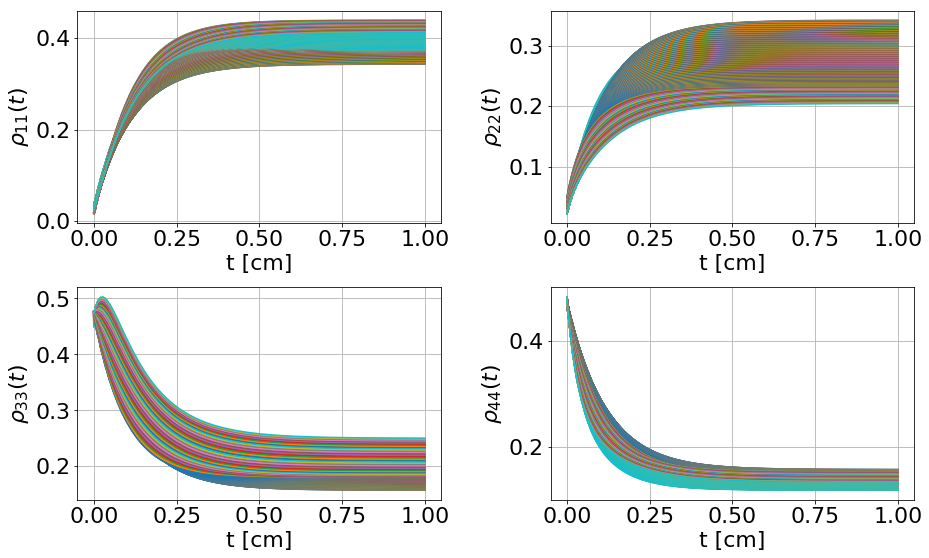

In [59]:
# Integrate Redfield equations to obtain evolution of rho under a certain initial condition
# NOTE: This section can take a long time to evaluate
teval = np.linspace(0,1,1e3)
rho0 = np.zeros(shape=(4,4))
rho0 = np.array([[0,0,0,0],
                 [0,0,0,0],
                 [0,0,0.5,0],
                 [0,0,0,0.5]])
c = 3e-5 # speed of light cm/fs
tevals = teval/c

RHO_EXC = [[0 for x in range(M)] for y in range(M)]

for A1 in range(M):
    for A2 in range(M):
        S = RED_EXC[A1][A2]
        H0 = H_E[A1][A2]
        Ne = len(H0);
        S = np.reshape(S,(Ne**2,Ne**2))
        E_e,V_e = np.linalg.eigh(H0)
        rho0_exc = V_e.T@rho0@V_e
        x0  = np.reshape(rho0_exc,Ne**2,1)
        RHO_EXC[A1][A2] = RK4_integrate(S,teval,x0,0)
        
plot_rho(RHO_EXC,teval)

In [62]:
# Curve fit to exponential model to obtain the transfer times yP
from scipy.optimize import curve_fit

def fun(x,c0,c1,a):
    #return np.squeeze( (c2-c1) + c1*np.exp(-a*x) - c2*np.exp(-b*x))
    return np.squeeze( c0 + c1*(1-np.exp(-a*x)) )

WOPT = [[0 for x in range(M)] for y in range(M)]
FIT  = [[0 for x in range(M)] for y in range(M)]
GOPT = np.zeros(shape=(M,M))
RISE = np.zeros(shape=(M,M))
FALL = np.zeros(shape=(M,M))
C0 = np.zeros(shape=(M,M))
C1 = np.zeros(shape=(M,M))

for i in range(M):
    for j in range(M):
        rhoM = RHO_EXC[i][j]
        rho1 = np.real(rhoM[0,:])
        lb = np.zeros(shape=(1,3))
        ub = np.array([1,10,50])
        x0 = np.squeeze(np.random.rand(1,3)*(ub-lb) + lb )
        popt,pcov = curve_fit(fun,teval,rho1,p0=x0,bounds=(0,[1,10,50]),maxfev=1000000)
        fit = fun(teval,popt[0],popt[1],popt[2])
        WOPT[i][j] = popt
        RISE[i,j] = popt[2]
        C0[i,j] = popt[0]
        C1[i,j] = popt[1]
        FIT[i][j] = fit
        GOPT[i,j] = np.sum((fit-rho1)*2)

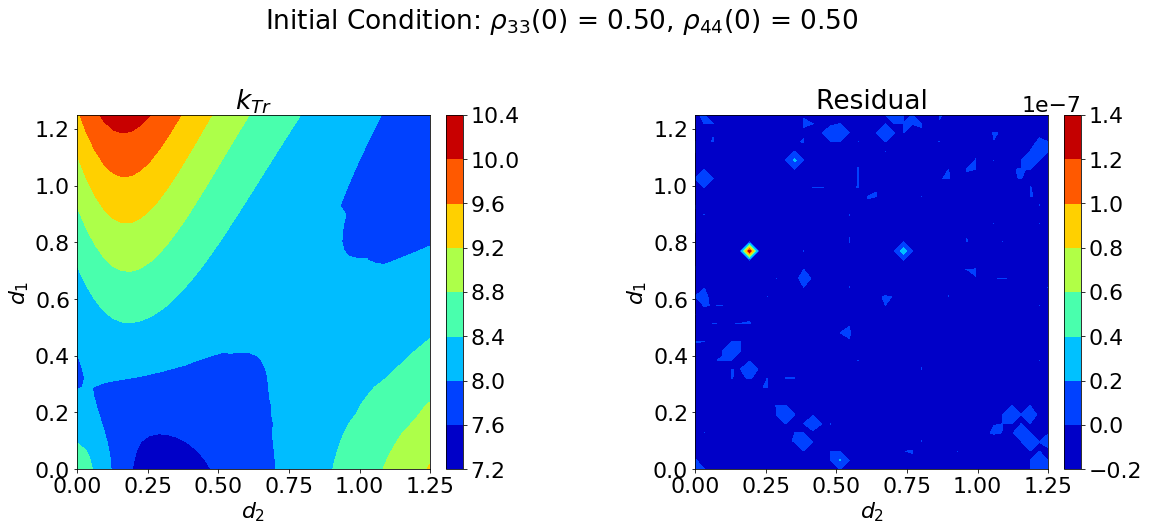

In [815]:
# Look at the transfer rate map
d1p,d2p = np.meshgrid(d1,d2,indexing='xy')       
fig = plt.figure(figsize = (18,15))
plt.rcParams.update({'font.size': 22})
gs = gridspec.GridSpec(2,2) 
gs.update(wspace=0.6, hspace=0.3) # set the spacing between axes.
ax1 = plt.subplot(gs[0]); 
ax2 = plt.subplot(gs[1]);
im1 = ax1.contourf(d2p,d1p,RISE,cmap='jet')
plt.colorbar(im1,ax=ax1,fraction=0.046, pad=0.04)
ax1.set_xlabel(r'$d_2$')
ax1.set_ylabel(r'$d_1$')
ax1.set_title(r'$k_{Tr}$')
im2 = ax2.contourf(d2p,d1p,GOPT,cmap='jet')
plt.colorbar(im2,ax=ax2,fraction=0.046, pad=0.04)
ax2.set_xlabel(r'$d_2$')
ax2.set_ylabel(r'$d_1$')
ax2.set_title('Residual')
plt.suptitle(r'Initial Condition: $\rho_{33}(0)$ = %4.2f, $\rho_{44}(0)$ = %4.2f ' %(rho0[2,2],rho0[3,3]) );

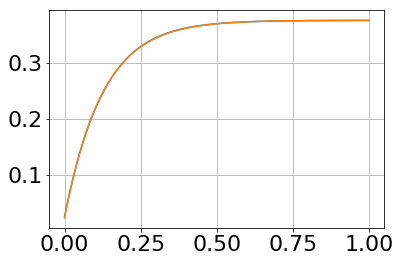

In [78]:
# Evaluate different terms of the fit
for i in [10]:
    for j in [11]:
        plt.plot(teval,np.real(RHO_EXC[i][j][0,:]))
        plt.plot(teval,FIT[i][j])
plt.grid(True)

In [1131]:
# Create the datasets {xp,yp} for GPR model training
M = 40
xp = np.zeros(shape=(M**2,2)); yp = np.zeros(shape=(M**2,1))
count = 0
for i in range(M):
    for j in range(M):
        xp[count,:] = np.array( [displ[0,i],displ[0,j]])
        yp[count] = RISE[i,j]
        count = count +1

In [1132]:
### Gaussian Process Regression ###

In [1133]:
def standard_normalize(x):
    x_means = np.mean(x,axis=1)[:,np.newaxis]
    x_sigma = np.std(x,axis=1)[:,np.newaxis]
    for i in range(len(x_sigma)):
        if x_sigma[i] == 0:
            x_sigma[i] = 1
    x_standard = (x - x_means)/x_sigma
    return x_standard
def pca_sphere(x):
    x_std = standard_normalize(x)
    Cov = x_std@x_std.T
    E,V = np.linalg.eigh(Cov)
    x_sphere = V.T@x_std
    return x_sphere

In [1134]:
# gradient descent function 
def conj_gradient_descent(g,alpha,beta,norm,steprule,max_its,w0):

    # compute gradient module using autograd
    gradient = grad(g)

    # run the gradient descent loop
    weight_history = [w0] # weight history container
    cost_history = [g(w0)] # cost function history container
    #dtemp = gradient(w0)
    dtemp = 0;
    
    for k in range(1,max_its):
        # evaluate the gradient
        grad_eval = gradient(w0)

        # take (momentum-accelerated) gradient descent step
        if norm == 'component':
            d = (1-beta)*dtemp + beta*np.sign(grad_eval)*np.sqrt(len(w0))
        elif norm == 'full':
            grad_eval = grad_eval/np.linalg.norm(grad_eval)
            d = (1-beta)*dtemp + beta*grad_eval
        else:
            d = (1-beta)*dtemp + beta*grad_eval
            
        wtemp = w0;   
        w0 = w0 - alpha*d
        
        if steprule == 'backtrack':
            t = 0.8
            #alpha = 1
            h = g(wtemp)+gradient(wtemp).T@(w0-wtemp)+1/(2*alpha)*np.linalg.norm(w0-wtemp)**2
            while g(w0) > h:
                alpha = t*alpha
                w0 = w0 - alpha*d
                h = g(wtemp)+gradient(wtemp).T@(w0-wtemp)+1/(2*alpha)*np.linalg.norm(w0-wtemp)**2
                wtemp = w0
            w0 = w0 - alpha*d
        elif steprule == 'diminishing':
            alpha = 1/k
        else:
            alpha = alpha
                
        
        # record weight and cost
        weight_history.append(w0)
        cost_history.append(g(w0))
        dtemp = d
    return weight_history,cost_history

In [1135]:
def kfoldpartition(k,xp,yp):
    P = len(xp);
    m = np.floor(P/k)
    nT = (k-1)*m; nS = int(P - nT);
    ind = np.random.permutation(P)
    indK = np.split(ind,k)
    XP = []; YP = []
    for i in range(k):
        XP.append(xp[indK[i],:])
        YP.append(yp[indK[i]])
    return XP,YP

def polymat(x,deg):
    m = np.shape(x); N = m[0]; C = m[1];
    if C == 1:
        if deg == 0:
            f = np.ones((N,1))
        elif deg == 1:
            f = np.concatenate( (np.ones((N,1)),x[:,0][:,np.newaxis]) ,axis=1)
        else:
            f = np.concatenate( (np.ones((N,1)),x[:,0][:,np.newaxis],x[:,0][:,np.newaxis]**2) ,axis=1)
    if C == 2:
        if deg == 0:
            f = np.ones((N,1))
        elif deg == 1:
            f = np.concatenate( (np.ones((N,1)),x[:,0][:,np.newaxis],x[:,1][:,np.newaxis]) ,axis=1)
        elif deg == 2:
            f = np.concatenate( (np.ones((N,1)),x[:,0][:,np.newaxis],x[:,1][:,np.newaxis],x[:,0][:,np.newaxis]**2,x[:,1][:,np.newaxis]**2) ,axis=1)
        else:
            f = np.concatenate( (np.ones((N,1)), x[:,0][:,np.newaxis],x[:,1][:,np.newaxis],x[:,0][:,np.newaxis]**2,x[:,1][:,np.newaxis]**2,x[:,0][:,np.newaxis]*x[:,1][:,np.newaxis]) ,axis=1)
    elif C == 3:
        if deg == 0:
            f = np.ones((N,1))
        elif deg == 1:
            f = np.concatenate( (np.ones((N,1)),x[:,0][:,np.newaxis],x[:,1][:,np.newaxis],x[:,2][:,np.newaxis]) ,axis=1)
        elif deg == 2:
            f = np.concatenate( (np.ones((N,1)),x[:,0][:,np.newaxis],x[:,1][:,np.newaxis],x[:,2][:,np.newaxis],x[:,0][:,np.newaxis]**2,x[:,1][:,np.newaxis]**2,x[:,2][:,np.newaxis]**2) ,axis=1)
        else:
            f = np.concatenate( (np.ones((N,1)), x[:,0][:,np.newaxis],x[:,1][:,np.newaxis],x[:,2][:,np.newaxis],x[:,0][:,np.newaxis]**2,x[:,1][:,np.newaxis]**2,x[:,2][:,np.newaxis]**2,x[:,0][:,np.newaxis]*x[:,1][:,np.newaxis],x[:,0][:,np.newaxis]*x[:,2][:,np.newaxis],x[:,1][:,np.newaxis]*x[:,2][:,np.newaxis]) ,axis=1)
    return f

def distanceMatrix(u,v):
    from scipy.spatial import distance_matrix 
    D1 = distance_matrix(u,v)
    return D1

def explKern(u,v,w,kern):
    K = np.zeros(shape=(len(u),len(v)))
    for i in range(len(u)):
        for j in range(len(v)):
            K[i,j] = kern(w,u[i,:],v[j,:])
    return K

def gpr_kernel(theta,xT,xS,kernel):
    DTT = distanceMatrix(xT,xT);
    DTS = distanceMatrix(xT,xS);
    DSS = distanceMatrix(xS,xS);
    if kernel == 'matern':
        # Issue: Kv(v,x) has singularity at x = 0. Must stabilitize DTT/DTS/DSS with 1e-9 on 0 entries. 
        kern = lambda w,x: w[0]*2**(1-w[1])/sp.special.gamma(w[1])*sp.special.kn(w[1],np.sqrt(2)*w[1]*np.abs(x))*(np.sqrt(2)*w[1]*np.abs(x))**w[1]
        K = kern(theta,DTT); Ks = kern(theta,DTS); Kss = kern(theta,DSS);
    elif kernel == 'gaussian':
        kern = lambda w,x: np.exp(-x**2/(2*w[0]))
        K = kern(theta,DTT); Ks = kern(theta,DTS); Kss = kern(theta,DSS);
    elif kernel == 'polynomial':
        kern = lambda w,x,y: (1 + np.dot(x.T,y))**w[0]-1
        K = explKern(xT,xT,theta,kern); Ks = explKern(xT,xS,theta,kern); Kss = explKern(xS,xS,theta,kern);
    else: 
        kern = lambda w,x: np.exp(-np.abs(x)/w[0])
        K = kern(theta,DTT); Ks = kern(theta,DTS); Kss = kern(theta,DSS);
    return K, Ks, Kss

def gpr_kernel_v2(theta,xT,xS,kernel):
    DTT = distanceMatrix(xT,xT);
    DTS = distanceMatrix(xT,xS);
    DSS = distanceMatrix(xS,xS);
    K = np.exp(-DTT**2/(2*theta**2)); Ks = np.exp(-DTS**2/(2*theta**2)); Kss = np.exp(-DTT**2/(2*theta**2));
    return K,Ks,Kss

def calcMuSigma(K,Ks,Kss,yT,poly):
    nP = 1
    nS = len(Kss)
    nT = len(yT)
    sigma_noise = 1e-9;
    mu =  np.dot(Ks.T, np.linalg.solve(K, yT))
    cov = Kss - np.dot(Ks.T, np.linalg.solve(K, Ks))
    stddev = np.sqrt(np.abs(np.diag(cov)))
    L  = np.linalg.cholesky(cov + sigma_noise*np.eye(nS))
    yS = mu.reshape(-1,1)  + np.dot(L, np.random.normal(size=(nS, nP)))
    return yS, mu, cov, stddev
   
def gpr(xT,yT,xS,sigma):
    K,Ks,Kss = gpr_kernel(sigma,xT,xS)
    yS,mu,cov,stddev = calcMuSigma(K,Ks,Kss,yT)
    return yS,mu,cov,stddev
   
def gpr_poly(xT,yT,xS,theta,kernel,deg):
    FT = polymat(xT,deg); FS = polymat(xS,deg);
    K,Ks,Kss = gpr_kernel_v2(theta,xT,xS,kernel); 
    nS = len(xS); nT = len(xT);
    beta = np.linalg.solve(np.dot(FT.T,np.linalg.solve(K,FT)), np.dot(FT.T,np.linalg.solve(K,yT)) )
    cov = 1/nT*np.dot((yT-np.dot(FT,beta)).T,np.linalg.solve(K,yT-np.dot(FT,beta)))
    return beta, cov, K, Ks, Kss, FT, FS

def y_kriging(x,beta,K,FT,xT,yT,theta,deg,kernel):
    d = distanceMatrix(xT,x)
    #r = theta[0]*np.exp(-d**2/(2*theta[1]))
    if kernel == 'matern':
        # Issue: Kv(v,x) has singularity at x = 0. Must stabilitize DTT/DTS/DSS with 1e-9 on 0 entries. 
        kern = lambda w,x: w[0]*2**(1-w[1])/sp.special.gamma(w[1])*sp.special.kn(w[1],np.sqrt(2)*w[1]*np.abs(x))*(np.sqrt(2)*w[1]*np.abs(x))**w[1]
        r = kern(theta,d)
    elif kernel == 'gaussian':
        kern = lambda w,x: np.exp(-x**2/(2*w[0]))
        r = kern(theta,d)
    elif kernel == 'polynomial':
        kern = lambda w,x,y: (1 + np.dot(x.T,y))**w[0]-1
        r = explKern(xT,x,theta,kern)
    else: 
        kern = lambda w,x: np.exp(-np.abs(x)/w[0])
        r = kern(theta,d)
    f = polymat(x,deg)
    
    mu = np.dot(f,beta) + np.dot(r.T,np.linalg.solve(K,yT-np.dot(FT,beta)))
    mse = cov**2*(1 - np.dot(r.T,np.linalg.solve(K,r)))
    
    return mu,mse

def y_kriging_v2(x,beta,K,FT,xT,yT,theta,deg,kernel):
    d = distanceMatrix(xT,x)
    r = np.exp(-d**2/(2*theta**2))
    f = polymat(x,deg)
    mu = np.dot(f,beta) + np.dot(r.T,np.linalg.solve(K,yT-np.dot(FT,beta)))
    mse = cov**2*(1 - np.dot(r.T,np.linalg.solve(K,r)))
    return mu,mse

def mse_kriging(x,cov,K,FT,xT,yT,theta,deg,kernel):
    d = distanceMatrix(xT,x)
    #r = theta[0]*np.exp(-d**2/(2*theta[1]))
    if kernel == 'matern':
        # Issue: Kv(v,x) has singularity at x = 0. Must stabilitize DTT/DTS/DSS with 1e-9 on 0 entries. 
        kern = lambda w,x: w[0]*2**(1-w[1])/sp.special.gamma(w[1])*sp.special.kn(w[1],np.sqrt(2)*w[1]*np.abs(x))*(np.sqrt(2)*w[1]*np.abs(x))**w[1]
        r = kern(theta,d)
    elif kernel == 'gaussian':
        kern = lambda w,x: np.exp(-x**2/(2*w[0]))
        r = kern(theta,d)
    elif kernel == 'polynomial':
        kern = lambda w,x,y: (1 + np.dot(x.T,y))**w[0]-1
        r = explKern(xT,x,theta,kern);
    else: 
        kern = lambda w,x: np.exp(-np.abs(x)/w[0])
        r = kern(theta,d)
    f = polymat(x,deg)
    return cov**2*(1 - np.dot(r.T,np.linalg.solve(K,r)))

def gpr_mle(theta,xT,yT,xS,kernel,deg):
    N = len(yT)
    beta,cov,K,Ks,Kss,FT,FS = gpr_poly(xT,yT,xS,theta,kernel,deg)
    #mle = -N/2*np.log(2*np.pi*cov**2) - 1/2*np.log(np.linalg.det(K+0*np.eye(N))) - 1/(2*cov**2)*np.dot( (yT-np.dot(FT,beta)).T,yT-np.dot(FT,beta))
    mle =  - 1/2*np.log(np.linalg.det(np.linalg.cholesky(K+1e-9*np.eye(N)))) - 1/(2*cov**2)*np.dot( (yT-np.dot(FT,beta)).T,yT-np.dot(FT,beta))  -N/2*np.log(2*np.pi*cov**2) 
    #mle = -1/2*np.log(np.linalg.det(K + 1e-9*np.eye(N))) - np.dot(np.dot( (yT-np.dot(FT,beta)).T,K),yT-np.dot(FT,beta))
    return -mle
    #return cov


In [1136]:
# Randomly Sample Data
P = 1600
nsamp = 20
D = 2
degree = np.array([0,1,2,2.5])
kernel = 'gaussian'

xT = np.zeros(shape=(int(P/nsamp),D));    yT = np.zeros(shape=(int(P/nsamp),1));
xS = np.zeros(shape=(int(P-P/nsamp),D));  yS = np.zeros(shape=(int(P-P/nsamp),1));
  
inds = np.random.permutation(P)
cS = 0
cT = 0
for i in range(P):
    I = inds[i]
    if i%nsamp == 0:
        xT[cT,:] = xp[I,:]
        yT[cT] = yp[I]
        cT += 1
    else:
        xS[cS,:] = xp[I,:]
        yS[cS] = yp[I]
        cS += 1

In [1137]:
# Hyperparameter Optimization
nruns = 5
cost_hist = []
wopt = []

for A in range(len(degree)):        
    deg = degree[A]
    fun = lambda w: gpr_mle(w,xT,yT,xS,kernel,deg)

    cost_min = np.zeros(nruns)
    weight_hist = []

    for i in range(nruns):
        w0 = np.random.rand(1)
        alpha = 0.01
        beta = 0.5
        steprule = 'standard'
        normalization = 'component'
        max_its = 200
        w1,g1 = conj_gradient_descent(fun,alpha,beta,normalization,steprule,max_its,w0)
        cost_hist.append(np.squeeze(g1))
        cost_min[i] = g1[-1]
        weight_hist.append(w1[-1])
    
    wopt.append(weight_hist[np.argmin(cost_min)])


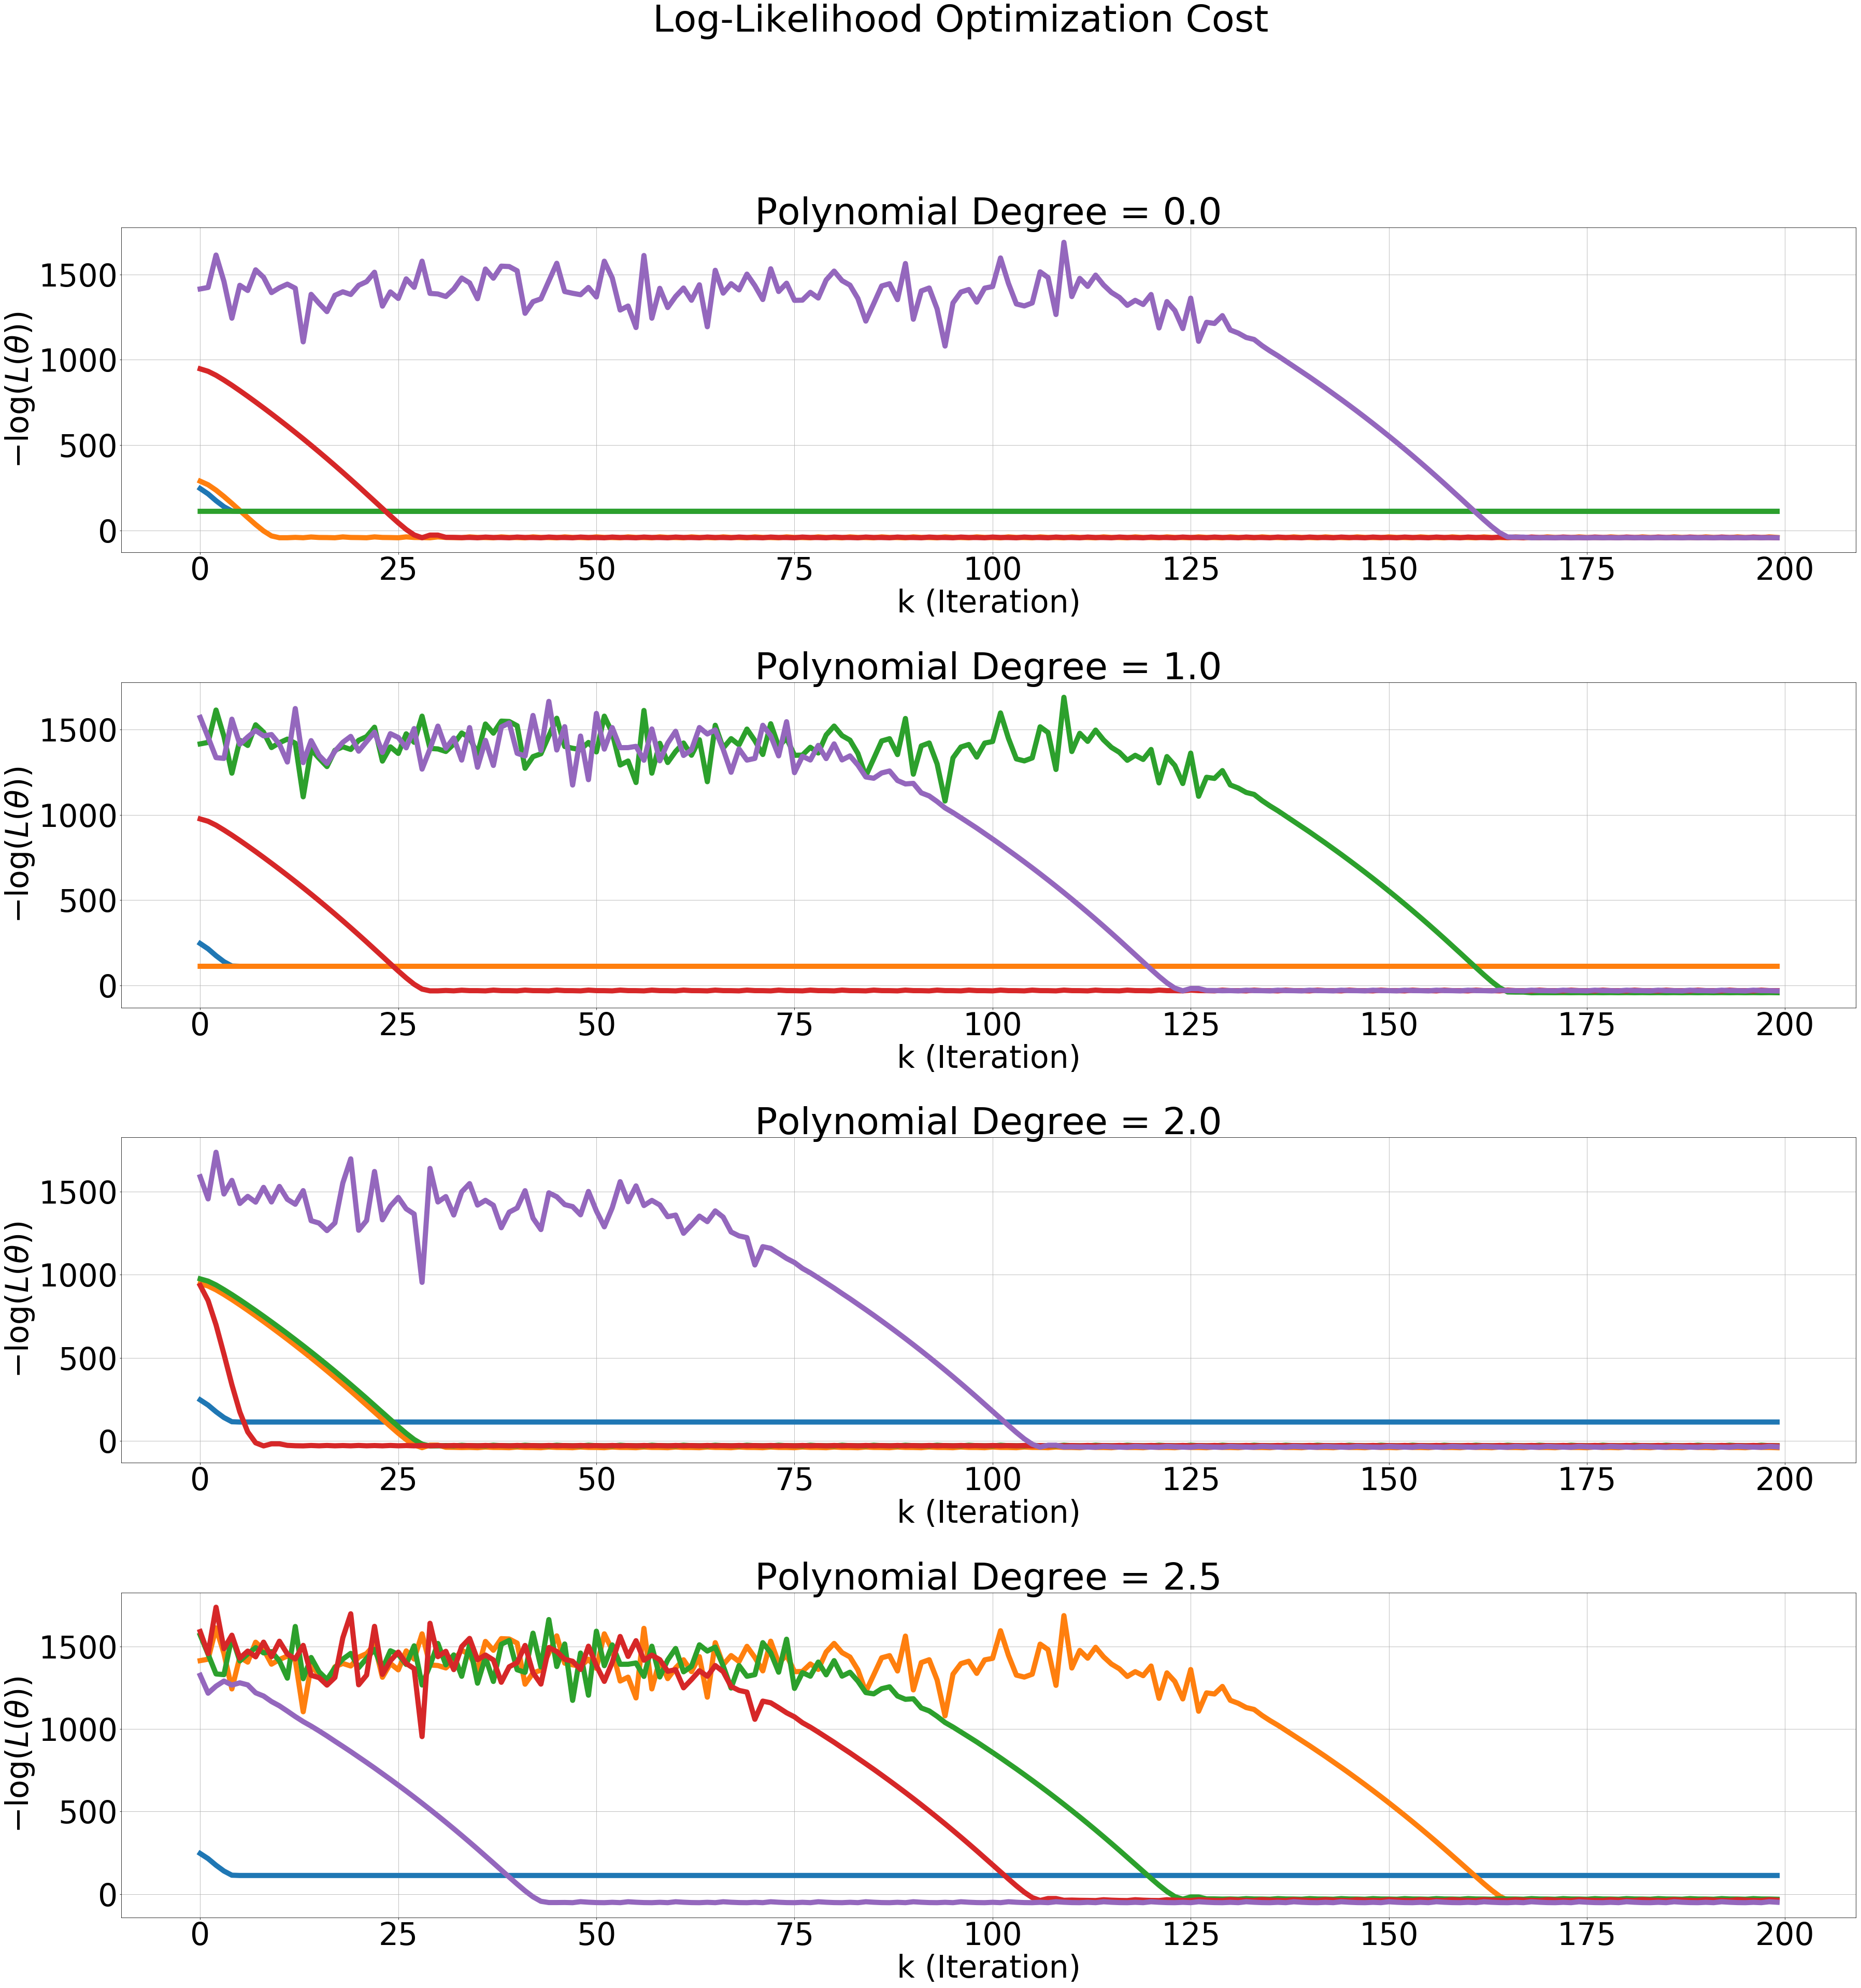

In [1174]:
# Plot cost function histories
fig = plt.figure(figsize = (60,60))
plt.rcParams.update({'font.size': 60})
gs = gridspec.GridSpec(4,1) 
gs.update(wspace=0.1, hspace=0.4) 

for a in range(len(degree)):
    ax1 = plt.subplot(gs[a]); 
    for i in range(nruns):
        ax1.plot(np.arange(0,max_its),cost_hist[a*i+i],linewidth=10)
    #ax1.set_title('Log-Likelihood Optimization Cost',Fontsize=16)
    ax1.set_ylabel(r'$-\log(L(\theta))$')
    ax1.set_xlabel('k (Iteration)')
    ax1.set_title('Polynomial Degree = ' + str(degree[a]))
    ax1.grid(True)
plt.suptitle('Log-Likelihood Optimization Cost')

#fig.savefig('Redfield_GPR_Hyperrparam_Results.svg',format='svg')

In [1139]:
# Construct Gaussian Process Models
kernel = 'gaussian'

YSS = []
MSEE = []
YPRED = []
CVscore = np.zeros(len(degree))

for A in range(len(degree)):
    
    theta = wopt[A]

    beta,cov,K,Ks,Kss,FT,FS = gpr_poly(xT,yT,xS,theta,kernel,deg)
    ypred = lambda a: y_kriging_v2(a,beta,K,FT,xT,yT,theta,deg,kernel)
    YPRED.append(ypred)
    
    # Cross-validation
    for i in range(len(yS)):
        a = np.array([xS[i,0],xS[i,1]])[np.newaxis,:]
        u,v = ypred(a)
        CVscore[A] += (u-yS[i])**2
    CVscore[A] = CVscore[A]/len(yS)
    
    # High-density interpolation 
    M = 50
    s2 = np.linspace(0,1.25,M)
    ySS = np.zeros(shape=(M,M))
    MSE = np.zeros(shape=(M,M))
    count = 0
    for i in range(len(s2)):
        for j in range(len(s2)):
            a = np.array([s2[i],s2[j]])[np.newaxis,:]
            u,v = ypred(a)
            ySS[i,j] = u
            MSE[i,j] = v
    YSS.append(ySS); MSEE.append(MSE)

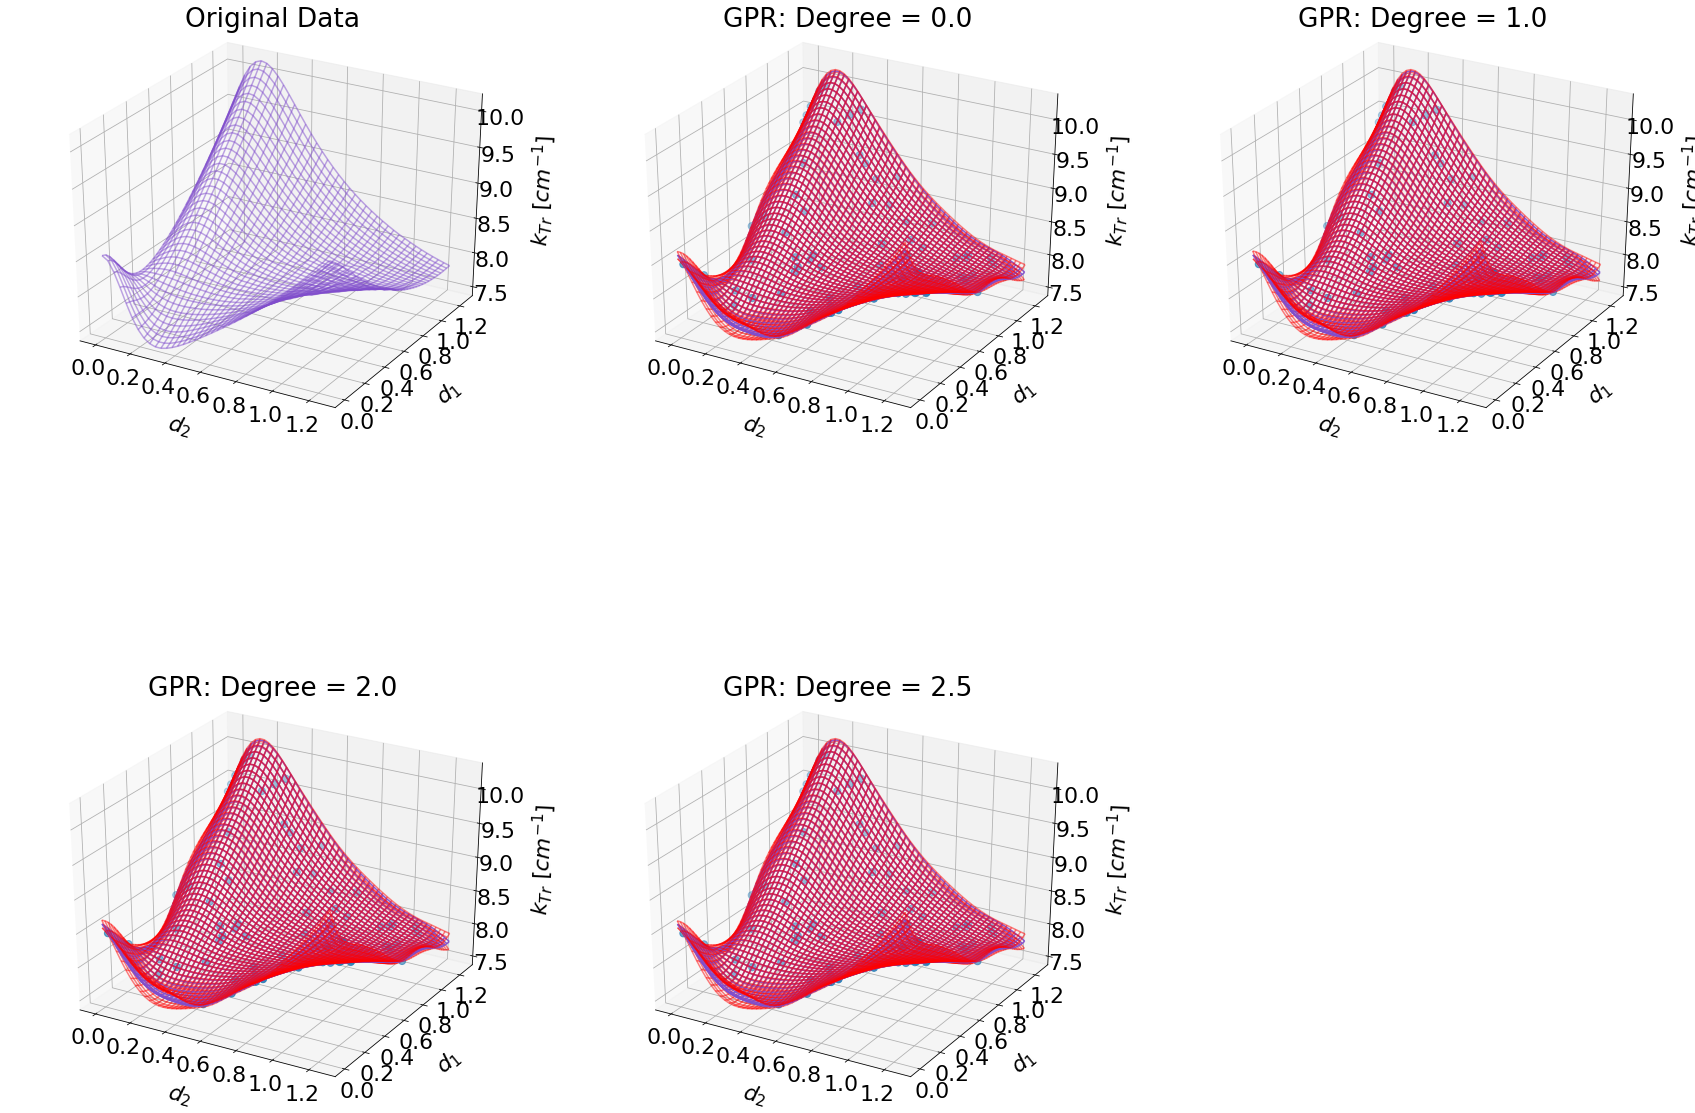

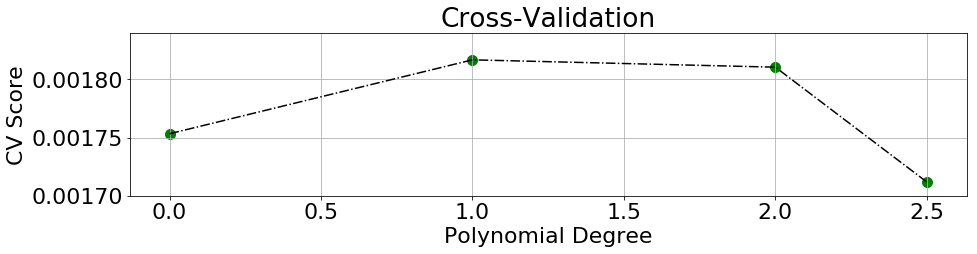

In [1177]:
xplot2,yplot2 = np.meshgrid(s2,s2)

fig = plt.figure(figsize = (30,20))
plt.rcParams.update({'font.size': 22})
gs = gridspec.GridSpec(2,3) 
gs.update(wspace=0.1, hspace=0.6) 

for a in range(len(degree)+1):  
    ax = plt.subplot(gs[a],projection='3d');
        
    ygpr = YSS[a-1]
    msegpr = MSEE[a-1]
    if a == 0:
        ax.plot_wireframe(d2p,d1p,RISE,alpha = 0.5,color = [0.5, 0.3, 0.8])
        ax.set_xlabel(r'$d_2$',labelpad=20)
        ax.set_ylabel(r'$d_1$',labelpad=20)
        ax.set_zlabel(r'$k_{Tr}$ $[cm^{-1}]$',labelpad=20)
        ax.set_title('Original Data',y=1.04)
    else:
        ax.plot_wireframe(yplot,xplot,ygpr,alpha = 0.9,color = [0.5, 0.3, 0.8])
        ax.plot_wireframe(yplot,xplot,ygpr+2*np.sqrt(msegpr),alpha = 0.5,color='r')
        ax.plot_wireframe(yplot,xplot,ygpr-2*np.sqrt(msegpr),alpha = 0.5,color='r')
        ax.scatter(xT[:,0],xT[:,1],yT,s=50)
        ax.set_xlabel(r'$d_2$',labelpad=20)
        ax.set_ylabel(r'$d_1$',labelpad=20)
        ax.set_zlabel(r'$k_{Tr}$ $[cm^{-1}]$',labelpad=20)
        ax.set_title('GPR: Degree = ' + str(degree[a-1]),y=1.04)
        
fig.savefig('Redfield_GPR_Results_2.svg',format='svg')
        

fig = plt.figure(figsize = (15,3))
plt.scatter(degree,CVscore,color=[0,0.5,0],s=100)
plt.plot(degree,CVscore,'k-.')
plt.xlabel('Polynomial Degree')
plt.ylabel('CV Score')
plt.title('Cross-Validation')
plt.ylim([1.7e-3, 1.84e-3])
plt.grid(True)

#fig.savefig('Redfield_GPR_CV_Results.svg',format='svg')